In [91]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
plt.style.use('fivethirtyeight')

In [7]:
pwd

'/home/daniel/Desktop/Projetos/mql_python/Projeto 1 -'

In [84]:
data = pd.read_excel('../version00/dados_win_dol.xlsx')

In [85]:
filter_col = [col for col in data if col.startswith('Close')]
dados = data[filter_col]


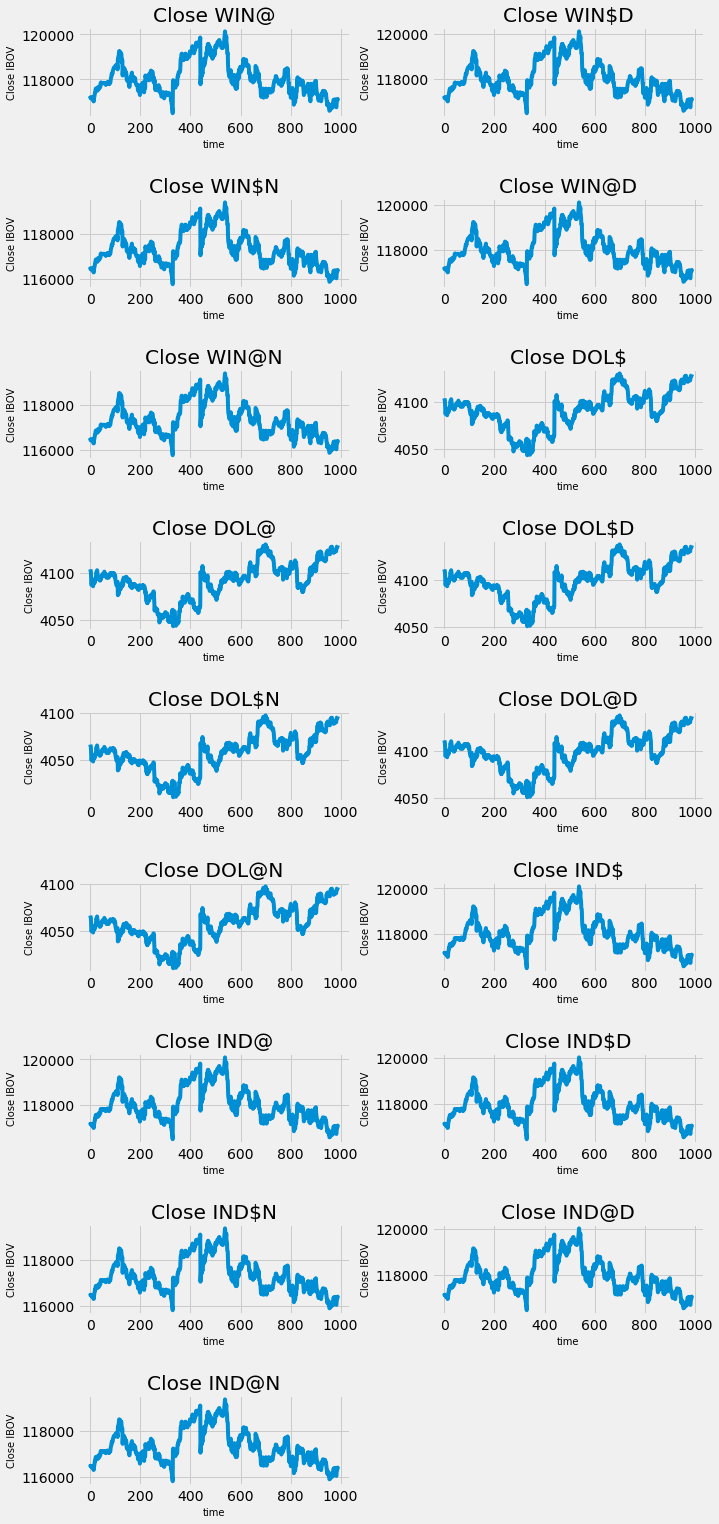

In [120]:
plt.figure(figsize=(10,25))
matplotlib.pyplot.subplots_adjust(wspace=.3, hspace=.9)


for i in range(1,len(dados.columns)):
    plt.subplot(9, 2,i)
    plt.plot(dados[dados.columns[i]].values)
    plt.title(dados.columns[i])
    plt.xlabel('time',fontsize=10)
    plt.ylabel('Close IBOV',fontsize=10)

plt.show()

In [126]:
indice = dados.filter(['Close IND$'])

In [136]:
dataset = indice.values
#math.ceil só ta dando um round
len_training_data = math.ceil(len(dataset)*.8)

In [139]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1)) #escala de 0 a 1 
scaled_data = scaler.fit_transform(dataset)

In [149]:
#split
train_data = scaled_data[:len_training_data]
len(train_data)

792

In [208]:
x_train, y_train = [],[]
for i in range(30,len(train_data)):
#     x_train.append(train_data[i-30:i])
    x_train.append(train_data[i-30:i,0])
#     y_train.append(train_data[i,0])
    y_train.append(train_data[i,0]) #proximo termo 



In [209]:
x_train, y_train = np.array(x_train), np.array(y_train)


In [210]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [211]:
#creating the lstm model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [212]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [214]:
model.fit(x_train, y_train, batch_size=2, epochs=4)

Epoch 1/4
762/762 [==============================] - 25s 32ms/step - loss: 0.0034
Epoch 2/4
762/762 [==============================] - 29s 38ms/step - loss: 0.0028
Epoch 3/4
762/762 [==============================] - 29s 38ms/step - loss: 0.0026
Epoch 4/4
762/762 [==============================] - 29s 38ms/step - loss: 0.0022


In [215]:
test_data = scaled_data[len_training_data - 30 : , :]

In [217]:
x_test, y_test = [], dataset[len_training_data : , :]
for i in range(30,len(test_data)):
#     x_train.append(train_data[i-30:i])
    x_test.append(train_data[i-30:i,0])


In [218]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [219]:
prediction = model.predict(x_test)

In [221]:
prediction = scaler.inverse_transform(prediction)

In [224]:
rmse = np.sqrt(np.mean(((prediction - y_test)**2)))
rmse

889.7995900685436

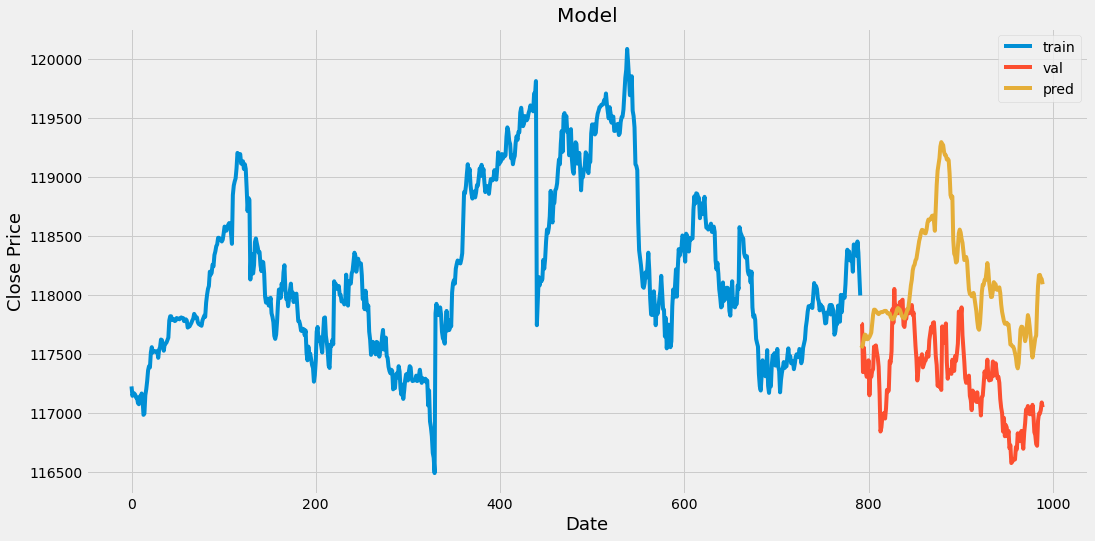

In [239]:
train = data[:len_training_data]
valid = data[len_training_data:].copy()

valid['Predictions'] = prediction
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close IND$'])
plt.plot(valid[['Close IND$', 'Predictions']])
plt.legend(['train','val','pred'])
plt.show()

In [13]:
data = data[['Close IND$','Close DOL$']].copy()
data.head()

,Close IND$,Close DOL$
0,117226,4104.025
1,117146,4102.511
2,117171,4102.007
3,117166,4096.456
4,117156,4087.373


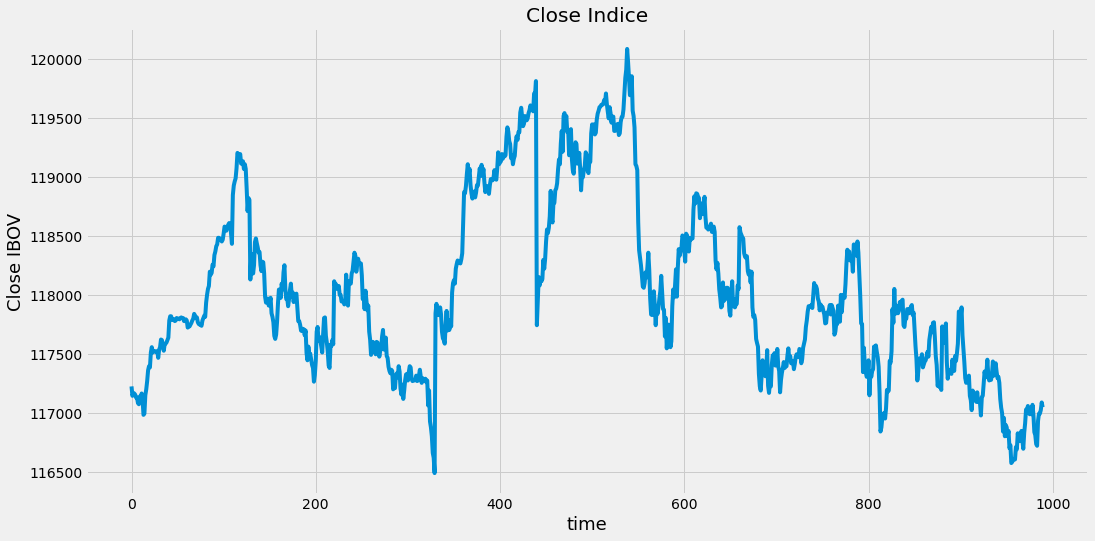

In [18]:
plt.figure(figsize=(16,8))
plt.title('Close Indice')
plt.plot(data['Close IND$'])
plt.xlabel('time',fontsize=18)
plt.ylabel('Close IBOV',fontsize=18)
plt.show()

In [20]:
data.columns

Index(['Close IND$', 'Close DOL$'], dtype='object')